# Random quantum circuits

# Circuit definition

In [2]:
%matplotlib inline
import numpy as np
from utils.gates import ONE_QUBIT_FIXED_GATE_SET, TWO_QUBITS_FIXED_GATE_SET, FIXED_GATE_SET, \
    ONE_QUBIT_PARAMETRISED_GATE_SET, TWO_QUBITS_PARAMETRISED_GATE_SET, PARAMETRISED_GATE_SET, \
    ONE_QUBIT_GATES, TWO_QUBITS_GATES, CircuitGate, GATES
from utils.states import State, STATES, DensityState
from utils.circuit import Circuit

from utils.draw_circuit import draw_circuit, save_circuit_drawing
from utils.random_gates import sample_random_gates, resolve_parameters
from utils.noise_channels import DepolarizingNoise, TRCNoise, SPAMNoise
from utils.circuit_metrics import fidelity

# np.set_printoptions(precision=3, suppress=True)

# define rng
RNG = np.random.default_rng(4242)

### STATES

### Pure - state vector representation

In [3]:
print(State(qubit_vector=np.array([[1], [0]], dtype=complex)))

print(STATES.psi_minus)
print(STATES.psi_minus.qubit_vector)

print(STATES.generate_zero_n_qubit_state(4))

print(STATES.generate_state([
    STATES.zero,
    STATES.psi_plus,
    STATES.phi_minus
]))

1 |0⟩
0.707 |01⟩ + -0.707 |10⟩
[[ 0.        +0.j]
 [ 0.70710678+0.j]
 [-0.70710678+0.j]
 [ 0.        +0.j]]
1 |0000⟩
0.5 |00100⟩ + -0.5 |00111⟩ + 0.5 |01000⟩ + -0.5 |01011⟩


### Mixed - denisty matrix representation
- used for noisy circuits only

In [20]:
density_state = DensityState.from_state(STATES.zero)
print(density_state)

q = 0
density_state.apply_1q_channel(SPAMNoise().kraus_prep(q), q)
density_state.apply_unitary(GATES.X.target_qubit_matrix)
print(density_state)
density_state.apply_1q_channel(DepolarizingNoise().kraus_for_1q("X", q), q)
# density_state.apply_1q_channel(TRCNoise().kraus_for("H", q), q)

# print(TRCNoise().kraus_for("H", q))

print(density_state)
# print(density_state.rho)
print(density_state.get_probabilities_str())

1 |0⟩
0.001 |0⟩⟨0| + 0.999 |1⟩⟨1|
0.00167 |0⟩⟨0| + 0.998 |1⟩⟨1|
P(|0⟩) = 0.002
P(|1⟩) = 0.998


### GATES

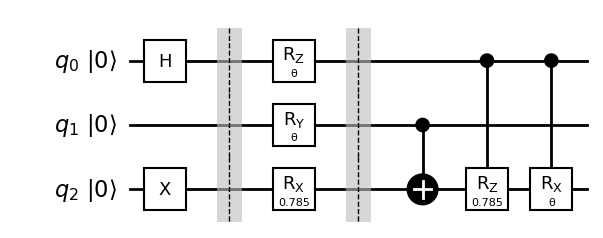

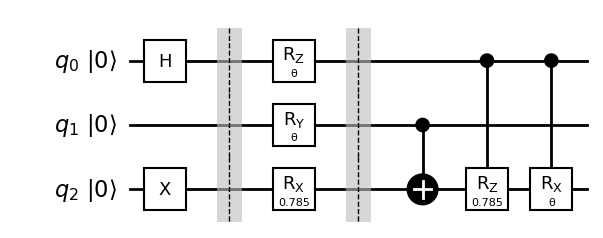

In [5]:
num_of_qubits = 3
gates=[
        [
            CircuitGate(GATES.X, target_qubit=2),
            CircuitGate(GATES.H, target_qubit=0)
        ],
        [
            CircuitGate(GATES.init_Rx(np.pi / 4), target_qubit=2),
            CircuitGate(GATES.Ry, target_qubit=1),
            CircuitGate(GATES.Rz, target_qubit=0)
        ],
        [
            CircuitGate(GATES.CNOT, target_qubit=2, control_qubit=1),
            CircuitGate(GATES.init_CRz(np.pi / 4), target_qubit=2, control_qubit=0),
            CircuitGate(GATES.CRx, target_qubit=2, control_qubit=0),
        ]
    ]
draw_circuit(gates, num_of_qubits)

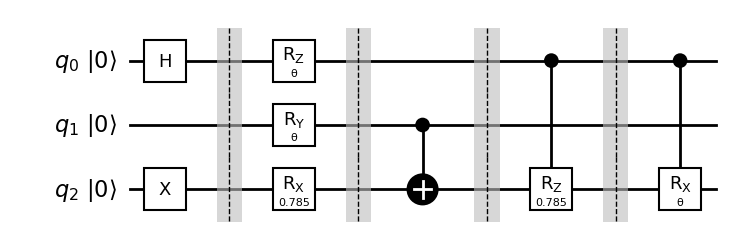

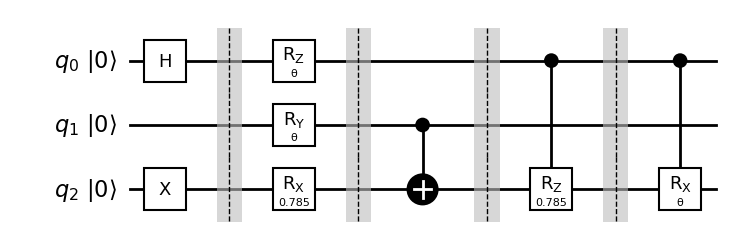

In [6]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(3),
    gates=gates,
    rng=RNG
)
draw_circuit(circuit.gates, num_of_qubits)

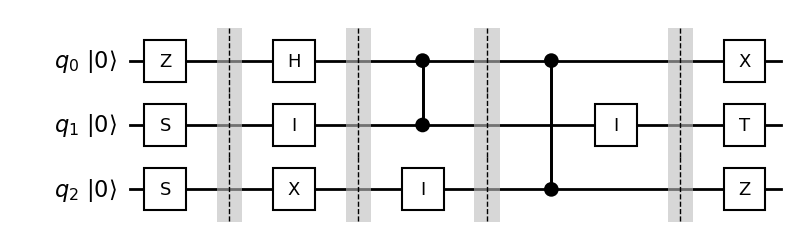

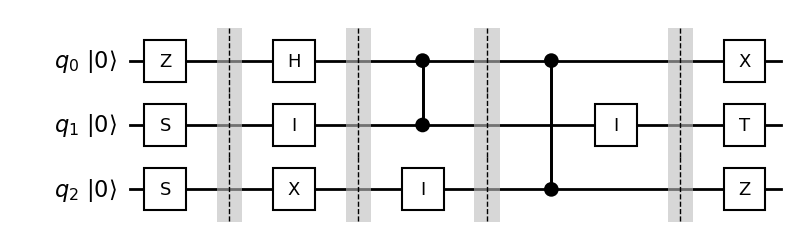

In [7]:
sampled_circuit_gates = sample_random_gates(num_of_qubits=num_of_qubits,
                                            layers=[
                                                ("1q", 2, ONE_QUBIT_FIXED_GATE_SET),
                                                # ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
                                                ("2q", 2, TWO_QUBITS_FIXED_GATE_SET),
                                                ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
                                                # ("mixed", 1, PARAMETRISED_GATE_SET),
                                            ],
                                            rng=RNG)

draw_circuit(sampled_circuit_gates, num_of_qubits)

In [8]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG
)

In [9]:
circuit.simulate_circuit()
print(circuit.state)

0.707 |100⟩ + -0.707 |101⟩


In [10]:
print(circuit.state.measure_all(rng=RNG))

['101']


In [11]:
print(circuit.state.measure_all(num_of_measurements=15, rng=RNG))

['100' '101' '101' '101' '101' '101' '101' '101' '100' '101' '101' '100'
 '100' '101' '101']


### Fidelity

The notion of *fidelity* generalizes the idea of overlap between quantum states.  
It always lies in the interval $[0,1]$, with higher values meaning the states are closer.

---

#### 1. Pure–pure states

For two pure states $|\psi\rangle, |\phi\rangle \in \mathbb{C}^N$, the fidelity is

$$
F(|\psi\rangle, |\phi\rangle) \;=\; \big|\langle \psi \mid \phi \rangle\big|^2.
$$

- This is simply the squared inner product of the two statevectors.  
- Intuitively: it is the probability of mistaking $|\phi\rangle$ for $|\psi\rangle$ in a measurement.

---

#### 2. Pure–mixed state

For a pure state $|\psi\rangle$ and a mixed state $\rho$, the fidelity is

$$
F(|\psi\rangle, \rho) \;=\; \langle \psi \mid \rho \mid \psi \rangle.
$$

- Here, $\rho$ is a density matrix (trace-one, positive semidefinite).  
- This formula reduces to the pure–pure case if $\rho = |\phi\rangle\!\langle\phi|$.

---

#### 3. Mixed–mixed states

For two mixed states $\rho$ and $\sigma$, the (Uhlmann) fidelity is defined as

$$
F(\rho, \sigma) \;=\; \Big( \operatorname{Tr}\,\sqrt{ \sqrt{\rho}\,\sigma\,\sqrt{\rho} } \,\Big)^2.
$$

- This reduces to the previous cases when one or both arguments are pure.  
- It is the standard way of measuring closeness of two general density matrices.

---

### Intuition

Suppose $|\psi_{\text{ideal}}\rangle$ is the perfect state from a noiseless simulation,  
and $\rho_{\text{noisy}}$ is the density matrix after noise channels (SPAM, depolarizing, TRC, etc.).

Then the fidelity

$$
F(|\psi_{\text{ideal}}\rangle, \rho_{\text{noisy}})
= \langle \psi_{\text{ideal}} \mid \rho_{\text{noisy}} \mid \psi_{\text{ideal}} \rangle
$$

has a simple interpretation:

- $F = 1$ → the noisy state is **identical** to the ideal one.  
- $F = 0$ → they are **orthogonal** (completely distinguishable).  
- $0 < F < 1$ → the noisy state is partially corrupted.  

Thus fidelity quantifies the **probability of success**:  
if you prepare the noisy state but check it against the ideal basis,  
fidelity tells you the probability that the outcome looks **exactly like the ideal**.


In [17]:
print(f"|0⟩: {STATES.zero}")
print(f"|+⟩: {STATES.plus}")
print("Fidelity:", f"{fidelity(STATES.zero, STATES.plus)}") 

print("Fidelity:", f"{fidelity(STATES.zero, density_state)}")

|0⟩: 1 |0⟩
|+⟩: 0.707 |0⟩ + 0.707 |1⟩
Fidelity: 0.4999999999999999
Fidelity: 0.5


# NOISE

## (i) Depolarizing Noise

**What it is:**  
Depolarizing noise models **gate infidelities**. After the ideal gate, the affected qubit undergoes a Pauli channel that mixes in the maximally mixed state with small probability.

**When it affects:**  
- Applied **after each gate**.  
- For **1-qubit gates**: the channel acts on the operated qubit.  
- For **2-qubit gates**: the channel acts **only on the target qubit** (consistent with the asymmetric role of control vs. target in e.g. CNOT).

**Typical rates:**  
- 1-qubit gates: $p_{1}^{(1q)} \sim 10^{-3}$  
- 2-qubit gates: $p_{1}^{(2q)} \sim 5 \times 10^{-3}$  
- Often gate-dependent overrides are used (e.g. $p(\mathrm{CNOT}) \approx 0.02$).

**Mathematical representation:**  
For a density matrix $\rho$, the one-qubit depolarizing channel is
$$
\mathcal{E}_{\mathrm{depol}}(\rho)
= (1-p)\,\rho + \frac{p}{3}\Big(X\rho X + Y\rho Y + Z\rho Z\Big).
$$

- For a 1-qubit gate on qubit $q$, apply $\mathcal{E}_{\mathrm{depol}}$ to $q$.  
- For a 2-qubit gate $(c,t)$, apply $\mathcal{E}_{\mathrm{depol}}$ to the **target qubit $t$ only**.

**Kraus operators (for the affected qubit):**
$$
K_{0}=\sqrt{1-p}\,I,\qquad
K_{1}=\sqrt{\tfrac{p}{3}}\,X,\qquad
K_{2}=\sqrt{\tfrac{p}{3}}\,Y,\qquad
K_{3}=\sqrt{\tfrac{p}{3}}\,Z,
$$
so that
$$
\mathcal{E}_{\mathrm{depol}}(\rho)=\sum_{i=0}^3 K_i\,\rho\,K_i^\dagger.
$$


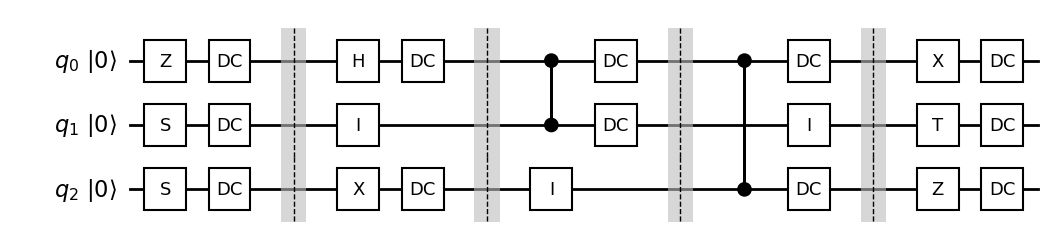

Ideal state: 0.707 |100⟩ + -0.707 |101⟩
Noisy state: 0.0784 |000⟩⟨000| + -0.00354 |000⟩⟨001| + -0.00354 |001⟩⟨000| + 0.0784 |001⟩⟨001| + 0.00765 |010⟩⟨010| + 0.00765 |011⟩⟨011| + 0.377 |100⟩⟨100| + -0.237 |100⟩⟨101| + -0.237 |101⟩⟨100| + 0.377 |101⟩⟨101| + 0.0368 |110⟩⟨110| + 0.0368 |111⟩⟨111|


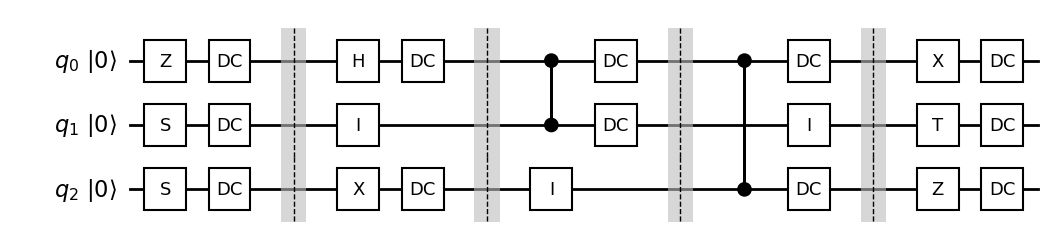

In [13]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(
        p1_1q=0.07, 
        p1_2q=0.09,
        overrides={'H': 0.08}
    )
)

draw_circuit(sampled_circuit_gates, num_of_qubits, depolarizing_noise=True)

circuit.simulate_circuit()

print("Ideal state:", circuit.state)          # noiseless result
print("Noisy state:", circuit.noisy_dm)    # with noise applied
# print("Fidelity:", f"{fidelity(circuit.state, circuit.noisy_state):.3f}")  # overlap ∈ [0,1]

## (ii) SPAM Noise

**What it is:**  
SPAM (State Preparation And Measurement) noise models **imperfect initialization** and **readout errors**.  
- **Preparation error:** when preparing $|0\rangle$, a flip to $|1\rangle$ can occur with probability $p_2$.  
- **Measurement error:** when measuring, the outcome bit can be flipped with probability $p_2$.

**When it affects:**  
- At the **start** (state preparation).  
- At the **end** (measurement).

**Typical rates:**  
- Preparation errors: $\sim 10^{-3}$.  
- Measurement errors: $\sim 1\%\text{–}5\%$ (platform-dependent).

**Mathematical representation (Pauli-$X$ channel):**  
Kraus operators
$$
K_{M0}=\sqrt{1-p_2}\,I,\qquad K_{M1}=\sqrt{p_2}\,X,
$$
so that
$$
\mathcal{E}_{\mathrm{SPAM}}(\rho)=(1-p_2)\rho+p_2\,X\rho X.
$$


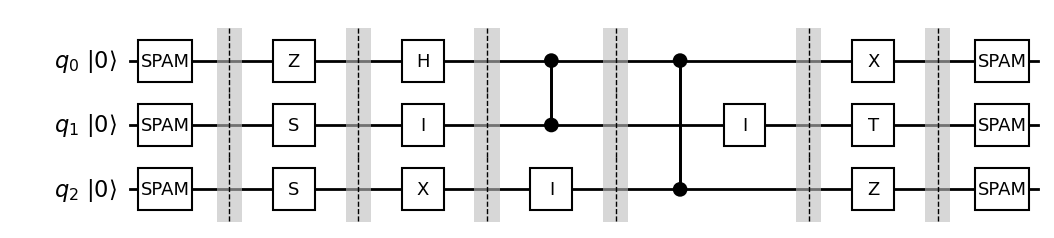

Ideal state: 0.707 |100⟩ + -0.707 |101⟩
Noisy state: 0.0357 |000⟩⟨000| + 0.0357 |001⟩⟨001| + 0.0118 |010⟩⟨010| + 0.0118 |011⟩⟨011| + 0.34 |100⟩⟨100| + -0.292 |100⟩⟨101| + -0.292 |101⟩⟨100| + 0.34 |101⟩⟨101| + 0.112 |110⟩⟨110| + -0.0486 |110⟩⟨111| + -0.0486 |111⟩⟨110| + 0.112 |111⟩⟨111|


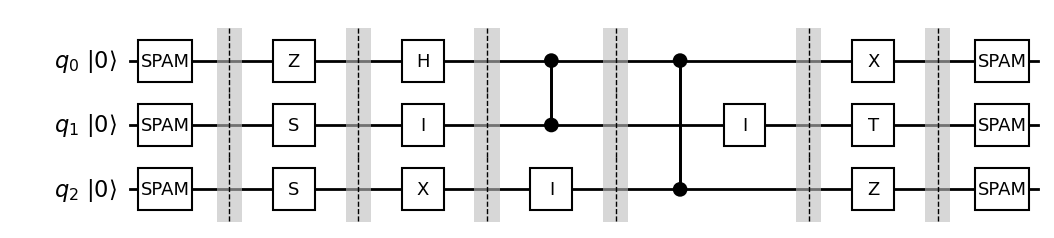

In [14]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    spam_noise=SPAMNoise(
        p_prep_default=0.05, 
        p_meas_default=0.05,
        prep_overrides={1: 0.08},
        meas_overrides={1: 0.2}
    )
)

draw_circuit(sampled_circuit_gates, num_of_qubits, spam_noise=True)

circuit.simulate_circuit()

print("Ideal state:", circuit.state)          # noiseless result
print("Noisy state:", circuit.noisy_dm)    # with noise applied
# print("Fidelity:", f"{fidelity(circuit.state, circuit.noisy_state):.3f}")  # overlap ∈ [0,1]


## (iii) TRC Noise (Thermal Relaxation and Dephasing)

**What it is:**  
The TRC channel models two key physical processes during a gate of duration \(T_g\):

- **Amplitude damping (energy relaxation, \(T_1\))** — population decays toward \(\left|0\right\rangle\).  
- **Dephasing (loss of phase coherence, \(T_2\)).**

We assume the **low-temperature limit** (\(\Theta \approx 0\)), so no thermal excitation occurs.

**When it acts:**

- After every gate with **nonzero duration** \(T_g\).  
- Independently on each qubit touched by the gate.  
- Gates with zero duration (e.g., virtual-\(Z\) rotations, barriers, identity placeholders) have **no TRC effect**.


**Customary scales:**

- Relaxation and dephasing times: \(T_1, T_2 \sim 10\text{--}100\,\mu\mathrm{s}\).  
- Gate durations: \(T_g \sim 10\text{--}100\,\mathrm{ns}\).


### Channel definitions

The paper distinguishes **two regimes**:

#### Case 1: \(T_2 \le T_1\)

Per-gate probabilities:
$$
\begin{aligned}
p_{\text{reset}} &= 1 - e^{-T_g/T_1}, \\
p_Z &= (1 - p_{\text{reset}})\,\frac{1 - \big(e^{-T_g/T_2}\big)\big/ \big(e^{-T_g/T_1}\big)}{2}, \\
p_I &= 1 - p_{\text{reset}} - p_Z .
\end{aligned}
$$

Effective channel:
$$
\mathcal{E}(\rho) \;=\; p_I\,\rho \;+\; p_Z\, Z \rho Z \;+\; p_{\text{reset}}\, \left|0\right\rangle \!\left\langle 0\right| \, .
$$


#### Case 2: \(T_1 < T_2 \le 2T_1\)

The expressions above no longer define a completely positive map.  
The paper uses a **CPTP channel** (via a Choi matrix, Eq. (5)) that can be implemented as:

- First apply an **amplitude-damping** channel with rate
  $$
  \gamma \;=\; 1 - e^{-T_g/T_1}.
  $$
- Then apply **pure dephasing** so that coherences decay as
  $$
  e^{-T_g/T_2}.
  $$

This can be enforced by defining a pure-dephasing time \(T_\phi\) such that
$$
\frac{1}{T_2} \;=\; \frac{1}{2T_1} \;+\; \frac{1}{T_\phi}\, .
$$


### Kraus operator form (for \(T_2 \le T_1\))

$$
K_0=\begin{pmatrix}1&0\\[2pt]0&\sqrt{\,1-p_{\text{reset}}\,}\end{pmatrix},\quad
K_1=\begin{pmatrix}0&\sqrt{\,p_{\text{reset}}\,}\\[2pt]0&0\end{pmatrix},\quad
K_2=\sqrt{p_Z}\,Z .
$$


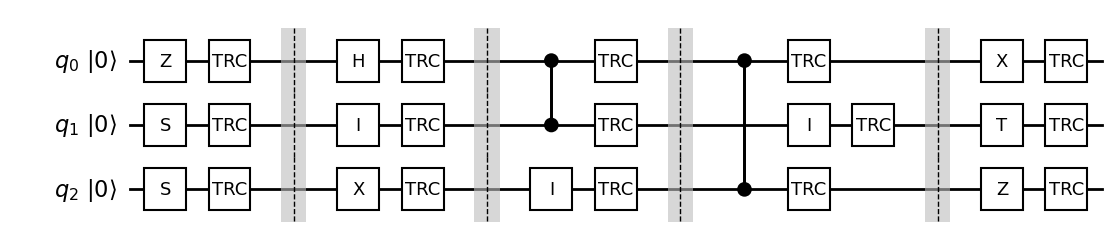

Ideal state: 0.707 |100⟩ + -0.707 |101⟩
Noisy state: 0.0522 |000⟩⟨000| + -0.0406 |000⟩⟨001| + -0.0406 |001⟩⟨000| + 0.0806 |001⟩⟨001| + 0.341 |100⟩⟨100| + -0.359 |100⟩⟨101| + -0.359 |101⟩⟨100| + 0.526 |101⟩⟨101|


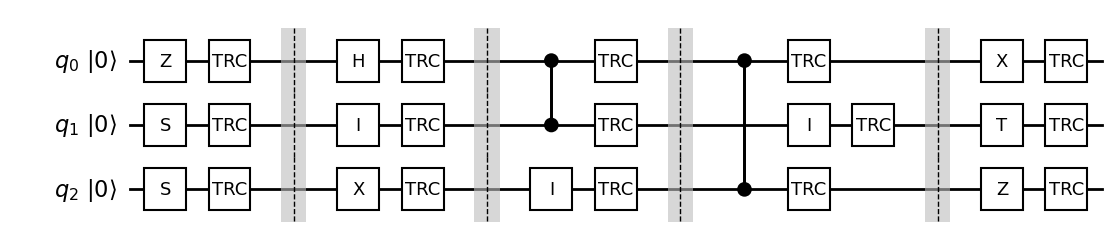

In [15]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    trc_noise=TRCNoise(
        T1_default=0.000002, 
        T2_default=0.000003
    )
)

draw_circuit(sampled_circuit_gates, num_of_qubits, trc_noise=True)

circuit.simulate_circuit()

print("Ideal state:", circuit.state)          # noiseless result
print("Noisy state:", circuit.noisy_dm)    # with noise applied
# print("Fidelity:", f"{fidelity(circuit.state, circuit.noisy_state):.3f}")  # overlap ∈ [0,1]


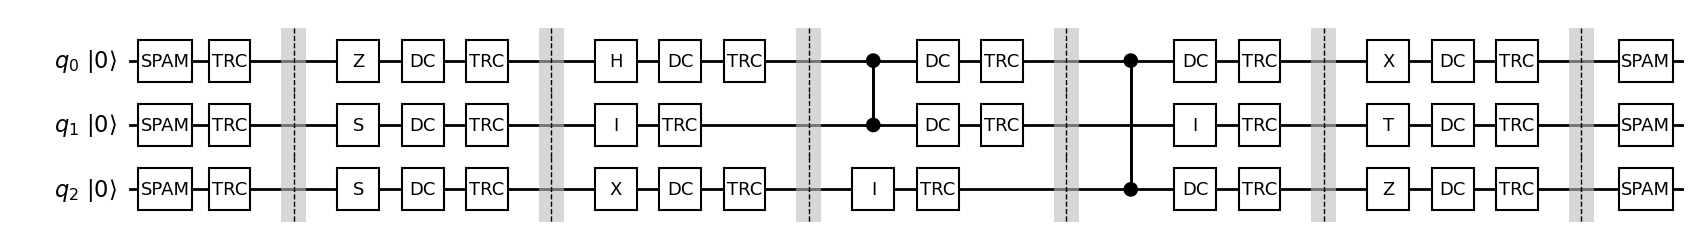

Ideal state: 0.707 |100⟩ + -0.707 |101⟩
Noisy state: 0.114 |000⟩⟨000| + -0.00769 |000⟩⟨001| + -0.00769 |001⟩⟨000| + 0.114 |001⟩⟨001| + 0.079 |010⟩⟨010| + -0.00154 |010⟩⟨011| + -0.00154 |011⟩⟨010| + 0.079 |011⟩⟨011| + 0.181 |100⟩⟨100| + -0.0344 |100⟩⟨101| + -0.0344 |101⟩⟨100| + 0.181 |101⟩⟨101| + 0.126 |110⟩⟨110| + -0.00688 |110⟩⟨111| + -0.00688 |111⟩⟨110| + 0.126 |111⟩⟨111|


In [14]:
circuit = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits),
    gates=sampled_circuit_gates,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(
        p1_1q=0.1, 
        p1_2q=0.2,
        overrides={'H': 0.2}
    ),
    spam_noise=SPAMNoise(
        p_prep_default=0.1, 
        p_meas_default=0.2,
        prep_overrides={1: 0.2},
        meas_overrides={1: 0.3}
    ),
    trc_noise=TRCNoise(
        T1_default=0.02, 
        T2_default=0.03
    )
)

draw_circuit(sampled_circuit_gates, num_of_qubits, True, True, True)

circuit.simulate_circuit()

print("Ideal state:", circuit.state)          # noiseless result
print("Noisy state:", circuit.noisy_dm)    # with noise applied
# print("Fidelity:", f"{fidelity(circuit.state, circuit.noisy_state):.3f}")  # overlap ∈ [0,1]


## Expressibility

**What it measures:**  
How well a parameterized quantum circuit (PQC) explores Hilbert space.

**How it is computed (paper):**  
1. Generate many random parameterizations of the same circuit ansatz.  
2. For each, compute the output quantum state.  
3. Compute pairwise fidelities between states.  
4. Compare the resulting fidelity distribution with the Haar-random distribution.  
5. The difference (e.g. KL divergence) quantifies *expressibility*.  

**Intuition:**  
- High expressibility → circuit can approximate Haar-random states.  
- Low expressibility → circuit explores only a small subspace.


## Entangling Capability

**What it measures:**  
How much entanglement the circuit can generate on average.

**How it is computed (paper):**  
1. Generate many random parameterizations of the same circuit ansatz.  
2. For each, compute the output state.  
3. Calculate bipartite entanglement entropy (von Neumann entropy of reduced density matrices).  
4. Average this entropy across samples.  

**Intuition:**  
- High entangling capability → circuit tends to create strongly entangled states.  
- Low entangling capability → circuit output remains weakly entangled or separable.


# Random circuit sampling

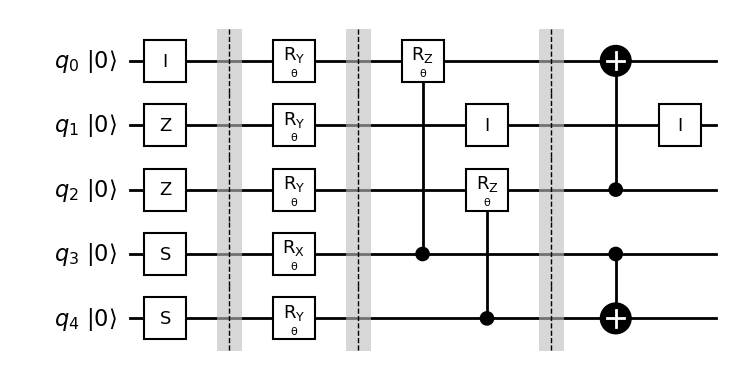

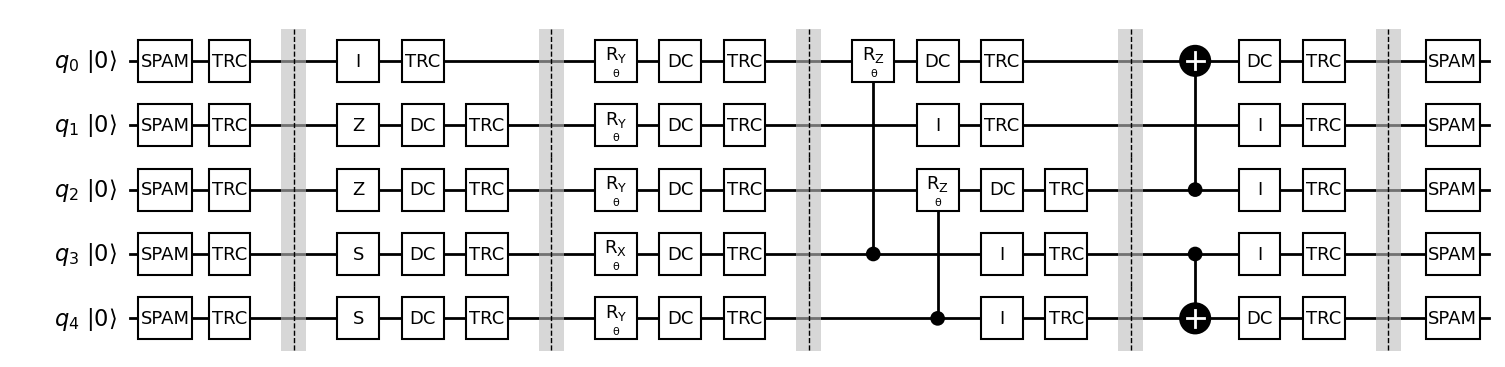

In [15]:
# circuit 1
num_of_qubits1 = 5

sampled_circuit_gates_parametrized_1 = sample_random_gates(
    num_of_qubits=num_of_qubits1,
    layers=[
        ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
        ("1q", 1, ONE_QUBIT_PARAMETRISED_GATE_SET),
        ("2q", 1, TWO_QUBITS_PARAMETRISED_GATE_SET),
        ("2q", 1, TWO_QUBITS_FIXED_GATE_SET),
        # ("1q", 1, ONE_QUBIT_FIXED_GATE_SET),
        # ("mixed", 1, PARAMETRISED_GATE_SET),
    ],
    rng=RNG
)

draw_circuit(sampled_circuit_gates_parametrized_1, num_of_qubits1)
draw_circuit(sampled_circuit_gates_parametrized_1, num_of_qubits1, True, True, True)

In [16]:
circuit_1 = Circuit(
    state=STATES.generate_zero_n_qubit_state(num_of_qubits1),
    gates=sampled_circuit_gates_parametrized_1,
    rng=RNG,
    depolarizing_noise=DepolarizingNoise(),
    spam_noise=SPAMNoise(),
    trc_noise=TRCNoise()
)


In [17]:
n = 10
dim = 2 ** circuit_1.state.num_of_qubits  # Hilbert space dimension

# Arrays to store pure vectors and noisy density matrices
states = np.zeros((n, dim, 1), dtype=complex)       # statevectors (ideal)
noisy_states = np.zeros((n, dim, dim), dtype=complex)  # density matrices

for i in range(n):
    circuit_1.simulate_circuit()

    # print("Ideal state:", circuit_1.state)        # noiseless statevector
    # print("Noisy state:", circuit_1.noisy_dm)     # density matrix with noise

    # Save
    states[i, :, :] = circuit_1.state.qubit_vector
    noisy_states[i, :, :] = circuit_1.noisy_dm.rho
    
    print("Fidelity:", f"{fidelity(circuit_1.state, circuit_1.noisy_dm):.3f}")  # overlap ∈ [0,1]
    circuit_1.reset_circuit()

AttributeError: 'Circuit' object has no attribute 'noisy_state'